# Lotka-Volterra Critical Threshold

We adopt the 2-population LotkaVolterra model introduced by Strobl et
al.:

$$\frac{dS}{dt} = r_{S} S \left(1 - \frac{S+R}{K}\right) \times (1-d_{D}D) - d_{S}S$$
$$\frac{dR}{dt} = r_{R} R \left(1 - \frac{S+R}{K}\right) - d_{R}R.$$

Both species follow a modified logistic growth model with growth rates
*r*<sub>*S*</sub> and *r*<sub>*R*</sub>, where the total population
(rather than the species population) is modified by the shared carrying
capacity *K*.

For this, we may derive an optimal treatment schedule, based on a critical treatment threshold:

$$N^{*} = \frac{K(r_{S} - d_{S})}{\biggl(\frac{K(r_{S} - d_{S})}{1.2 N_{0}} - r_{S} \biggr)e^{(r_{S} - d_{S}) \tau} + r_{S}}$$

In [66]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("../utils")
from myUtils import convert_ode_parameters,  calc_critical_treatment_threshold, calc_critical_treatment_interval
from odeModels import LotkaVolterraModel


In [67]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)
odeParamDic['N0'] = odeParamDic['n0']

81.0097902085616
0.49999999999999994
0.7091510181309452


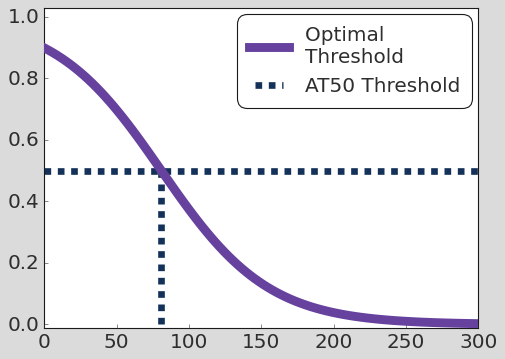

In [68]:
# Variation of threshold with critical interval

fig, ax = plt.subplots(1,1,figsize=(7,5))

tau_values = np.linspace(0, 300, 100)
n_stars = [calc_critical_treatment_threshold(tau=t,**odeParamDic) for t in tau_values]
plt.plot(tau_values, n_stars, linewidth = 8, color=colors['DRL_Monthly'], zorder=5, label = 'Optimal \nThreshold'); 

val = calc_critical_treatment_interval(n_crit = 0.5,**odeParamDic)
ax.hlines(xmin=0, xmax=max(tau_values), y=0.5, linestyles="--", linewidth=6, color=colors['AT'], label = 'AT50 Threshold')
ax.vlines(ymin=0, ymax=0.5, x=val, linestyles="--", linewidth=6, color=colors['AT'])
print(val)
print(calc_critical_treatment_threshold(tau=val,**odeParamDic))
print(calc_critical_treatment_threshold(tau=48,**odeParamDic))

plt.ylim(-0.01,1.03)
ax.tick_params(right = False, top = False)
# plt.xlabel("Treatment Interval"); plt.ylabel("Analytic Threshold"); 
plt.gca().legend(loc=1, fontsize=18, numpoints=1).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
# plt.savefig("../figures/fig_optimal_threshold.pdf")

In [69]:
model = LotkaVolterraModel()
model.SetParams(**odeParamDic)
print("Benefit of AT70 over AT50 is " 
      + str(model.CalcTtp(threshold=0.3) - model.CalcTtp(threshold=0.5)))

Benefit of AT70 over AT50 is -79.6049999999857


In [70]:
def calc_ttp(params, n_crit, interval):
    arg = n_crit
    model = LotkaVolterraModel(dt=1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=arg, atMethod='Threshold',
                    intervalLength=interval, t_end=4000, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max()

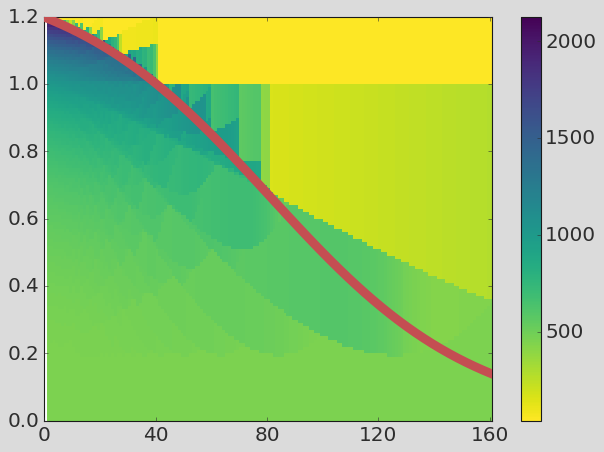

In [71]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import MaxNLocator

dx, dy = 1, 0.01

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = odeParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

n_stars = [calc_critical_treatment_threshold(tau=t,**odeParamDic)/odeParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/lotka_volterra_model_threshold.pdf"); plt.show()

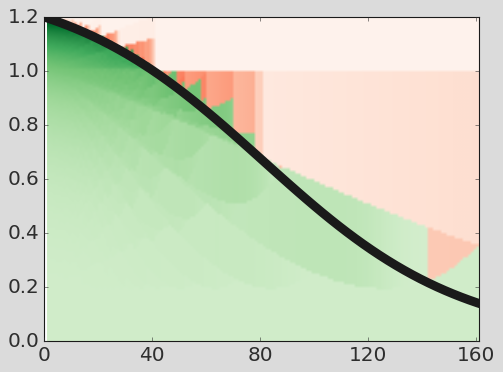

In [72]:
def calc_result(params, n_crit, interval):
    arg = n_crit
    model = LotkaVolterraModel(dt=1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=arg, atMethod='Threshold',
                    intervalLength=interval, t_end=4000, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max(), int(model.resultsDf.DrugConcentration.iloc[-1] > 0)

dx, dy = 1, 0.01

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_result)
ttp_values, drug_values = vectorized_calc_ttp(
    params = odeParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
drug_values = drug_values[:-1, :-1]

# Create custom colormap
cmap_red = plt.get_cmap('Reds')
cmap_green = plt.get_cmap('Greens')

cmap_combined = np.zeros((ttp_values.shape[0], ttp_values.shape[1], 3))
for i in range(ttp_values.shape[0]):
    for j in range(ttp_values.shape[1]):
        if drug_values[i, j] == 1:
            cmap_combined[i, j, :] = cmap_green(ttp_values[i, j] / np.max(ttp_values))[:3]
        else:
            cmap_combined[i, j, :] = cmap_red(ttp_values[i, j] / np.max(ttp_values))[:3]

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='k', label = 'Optimal\nThreshold'); 

im = ax.imshow(cmap_combined, origin='lower', extent=[tau_grid.min(), tau_grid.max(), crit_n_grid.min(), crit_n_grid.max()])
# fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.set_xlim(tau_grid.min(), tau_grid.max())
ax.set_ylim(crit_n_grid.min(), crit_n_grid.max())
ax.set_aspect(100)
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/lotka_volterra_model_threshold_binary.pdf"); plt.show()

The chaotic behaviour in TTP is atrributable to the discrete nature of the treatment intervals. To mitigate for this somewhat - we wish to vary the starting the day on which treatment starts (i.e. so that monthly treatment might be starting on days 10 and 40 etc instead of 0 and 30).

To do this, we will simulate an initial treatment period of varied length $\tau \prime$ (where $\tau \prime$ is less than the treatment interval $\tau$) at the start of treatment, before returning o the regular schedule.

0.8999999999999999
0.8999999999999999
0.8355032760783322
1120.0
0.900805057047575
      Time  DrugConcentration         S         R  TumourSize
35  1115.0                1.0  0.303898  0.590787    0.894685
36  1116.0                1.0  0.303469  0.592459    0.895928
37  1117.0                1.0  0.303045  0.594116    0.897161
38  1118.0                1.0  0.302627  0.595758    0.898386
39  1119.0                1.0  0.302215  0.597385    0.899600


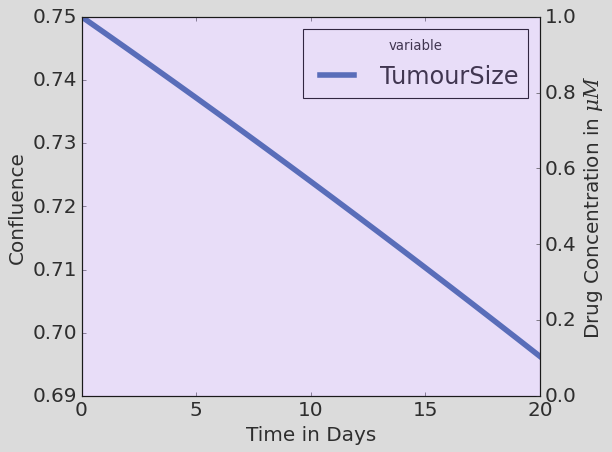

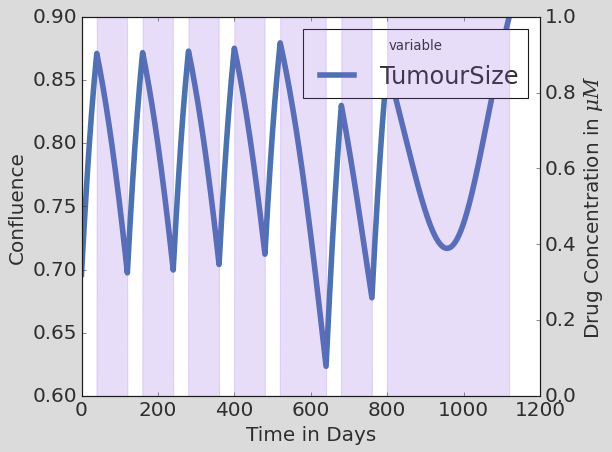

In [73]:

n_crit=0.95; params=odeParamDic; interval=40; offset=20

arg = n_crit
model = LotkaVolterraModel(dt=1); model.SetParams(**params)

# Simulate offset
initial_drug = n_crit < 1
model.Simulate([[0, offset, initial_drug]])

if model.resultsDf.TumourSize.iloc[-1] > 1.2 * params['N0']:
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    
else:
    new_params = params.copy()
    new_params['S0'] = model.resultsDf.S.iloc[-1]
    new_params['R0'] = model.resultsDf.R.iloc[-1]

    model2 = LotkaVolterraModel(dt=1); model2.SetParams(**new_params)
    rescaled_prog = 1.2 * params['N0'] / model.resultsDf.TumourSize.iloc[-1]
    model2.Simulate_AT(atThreshold=arg, atMethod='Threshold',
                    intervalLength=interval, t_end=1500, 
                    refSize = params['N0'], tumourSizeWhenProgressed=rescaled_prog)
    print(1.2 * params['N0'])
    print(1.2 * new_params['N0'])
    print(1.2 * new_params['S0'] + 1.2 * new_params['R0'])
    print(model2.resultsDf.Time.max())
    print(model2.resultsDf.TumourSize.iloc[-1])
    model2.resultsDf = model2.resultsDf[model2.resultsDf.TumourSize < 1.2 * params['N0']]

model.Plot()
model2.Plot()
print(model2.resultsDf.tail())

In [74]:
def calc_offset_ttp(params, n_crit, interval, offset):
    arg = n_crit
    model = LotkaVolterraModel(dt=1); model.SetParams(**params)

    # Simulate offset
    initial_drug = n_crit < 1
    model.Simulate([[0, offset, initial_drug]])

    if model.resultsDf.TumourSize.iloc[-1] > 1.2 * params['N0']:
        model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
        return model.resultsDf.Time.max()
    else:
        new_params = params.copy()
        new_params['S0'] = model.resultsDf.S.iloc[-1]
        new_params['R0'] = model.resultsDf.R.iloc[-1]

        model2 = LotkaVolterraModel(dt=1); model2.SetParams(**new_params)
        rescaled_prog = 1.2 * params['N0'] / model.resultsDf.TumourSize.iloc[-1]
        model2.Simulate_AT(atThreshold=arg, atMethod='Threshold',
                           intervalLength=interval, t_end=4000, 
                           refSize = params['N0'], tumourSizeWhenProgressed=rescaled_prog)
        model2.resultsDf = model2.resultsDf[model2.resultsDf.TumourSize < 1.2 * params['N0']]
        return model2.resultsDf.Time.max() + offset

def calc_ttp_repeats(params, n_crit, interval, output_func=np.mean):  
    N = 5
    N_reps = min(N, interval)
    ttp_values = np.zeros(int(N_reps))

    if interval < N:
        offset_vals = np.arange(0, interval)
    else:
        offset_vals = np.linspace(0, interval, N)
    
    for i, offset in enumerate(offset_vals):
        ttp_values[i] = calc_offset_ttp(params, n_crit, interval, offset)
    return output_func(ttp_values)


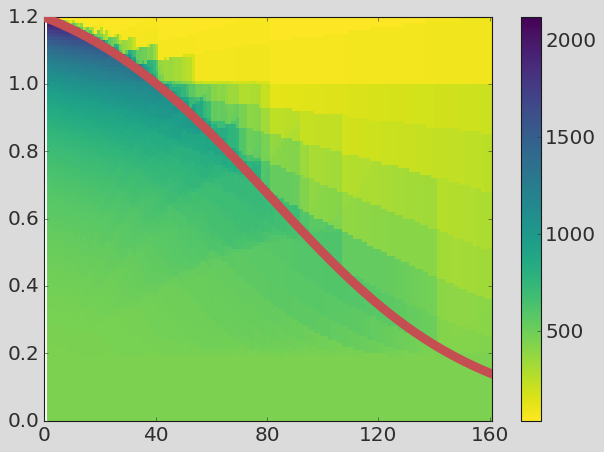

In [75]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import MaxNLocator

dx, dy = 1, 0.01

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]


vectorized_calc_ttp = np.vectorize(calc_ttp_repeats)
ttp_values = vectorized_calc_ttp(
    params = odeParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/lotka_volterra_model_threshold_mean.pdf"); plt.show()

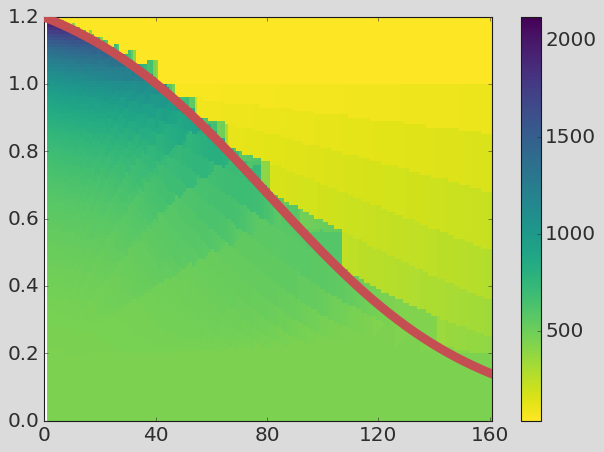

In [76]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import MaxNLocator

dx, dy = 1, 0.01

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]


calc_ttp_repeats_min = lambda params, n_crit, interval: calc_ttp_repeats(params, n_crit, interval, output_func=np.min)

vectorized_calc_ttp = np.vectorize(calc_ttp_repeats_min)
ttp_values = vectorized_calc_ttp(
    params = odeParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/lotka_volterra_model_threshold_min.pdf"); plt.show()

/Users/80024651/Documents/Moffitt/AT_Model_Comparison/lotka_volterra/../utils/myUtils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / denominator


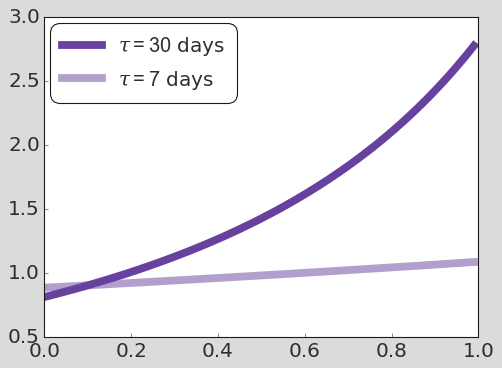

In [5]:
# Variation with turnover for different treatment time

plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(7, 5))

turnover_space = np.linspace(0, 1, 100)
n0 = odeParamDic['n0']; rs = odeParamDic['rS']

n_stars_30 = [calc_critical_treatment_threshold(tau=28,S0=n0,K=1, rS = rs, dS=(rs*turnover)) for turnover in turnover_space]
plt.plot(turnover_space, n_stars_30, linewidth = 7, label = r"$\tau = 30$ days", color=colors['DRL_Monthly']); 
n_stars_7 = [calc_critical_treatment_threshold(tau=7,S0=n0,K=1, rS = rs, dS=(rs*turnover)) for turnover in turnover_space]
plt.plot(turnover_space, n_stars_7, linewidth = 7, label = r"$\tau = 7$ days", color=colors['DRL_Monthly'], alpha=0.5); 
# plt.xlabel("Turnover"); plt.ylabel("Analytic Threshold"); 
ax.tick_params(right = False, top = False)
plt.gca().legend(loc=2, fontsize=18, numpoints=1).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
# plt.savefig("../figures/fig_threshold_vs_turnover.pdf")

## Depedence on patient parameters

/Users/80024651/Documents/Moffitt/AT_Model_Comparison/lotka_volterra/../utils/myUtils.py:111: RuntimeWarning: divide by zero encountered in divide
  pre_exp = (numerator / (prog * S0)) + rS
/Users/80024651/Documents/Moffitt/AT_Model_Comparison/lotka_volterra/../utils/myUtils.py:111: RuntimeWarning: invalid value encountered in divide
  pre_exp = (numerator / (prog * S0)) + rS
/Users/80024651/Documents/Moffitt/AT_Model_Comparison/lotka_volterra/../utils/myUtils.py:113: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator
/var/folders/by/xwl2vmrj5dl9941qxr6lr2t4002mml/T/ipykernel_88717/4081380556.py:18: RuntimeWarning: invalid value encountered in divide
  ratio = critical_thresholds / n0_mesh


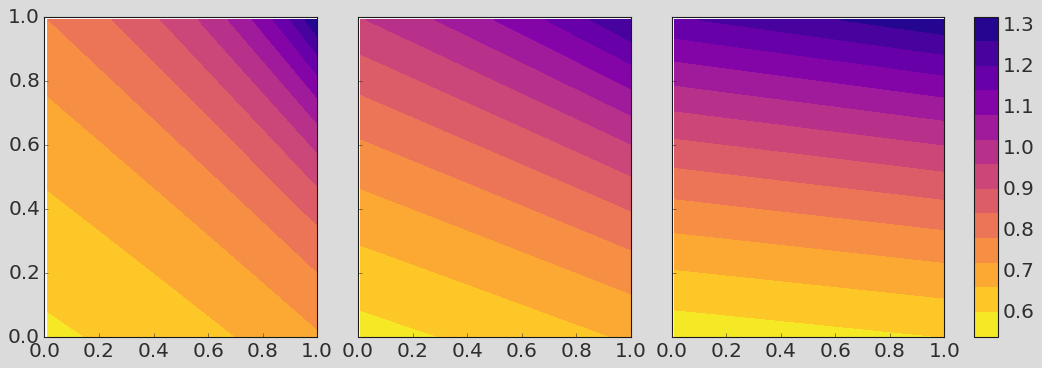

In [6]:
plt.rcParams['font.size'] = '18'

# Define the range of n0 and turnover values
n0_values = np.linspace(0, 1, 100)
turnover_values = np.linspace(0, 1, 100)
K_values = [1.5, 3, 10]

# Create a mesh grid of n0 and turnover values
n0_mesh, turnover_mesh = np.meshgrid(n0_values, turnover_values)

fig, axs = plt.subplots(1, len(K_values), figsize=(15, 5), sharex=True, sharey=True)

for i, K in enumerate(K_values):
    gridParamDic = convert_ode_parameters(n0=n0_mesh, rFrac=0.001, cost=0, turnover=turnover_mesh)
    gridParamDic['K'] = K
    
    critical_thresholds = calc_critical_treatment_threshold(tau=28, **gridParamDic)
    ratio = critical_thresholds / n0_mesh
    
    c = axs[i].contourf(n0_mesh, turnover_mesh, ratio, cmap='plasma_r', levels=12)
    axs[i].tick_params(right = False, top = False)
    # axs[i].set_xlabel(r'$n_{0}$')
    
    # axs[i].set_title(f'$K = {K}$')

# axs[0].set_ylabel('Turnover')


# Adjust the spacing between subplots and colorbar
plt.subplots_adjust(wspace=0.15, hspace=0.1, bottom=0.1, right=0.875)
cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
cbar_ax.tick_params(size=0)
fig.colorbar(c, cax=cbar_ax,ticks=np.arange(0, 1.5, 0.1))
# plt.savefig("../figures/fig_threshold_param_space.pdf")
# Show the plot
plt.show()


## Dependence on the Progression threshold

Based on RECIST, progression has been defined as 20\% growth from the initial tumor size. However this metric is not well suited to adaptive therapy; it was designed to quantify a significant growth under continuous treatment (implying the tumour no longer responses to the current treatment course). Given that we may allow growth beyond the initial size, without losing control of the initial tumor, we may reconsider what would be most appropriate here.

Ignoring the fact that an absolute growth percentage may not be most appropriate anyway (as we are not trying to detect growth under treatment, but rather limit the absolute tumor burden to tolerable levels, which may depend on the carrying capacity), we may consider an arbitrary growth limit $\alpha$:

$$N^{*} = \frac{K(r_{S} - d_{S})}{\biggl(\frac{K(r_{S} - d_{S})}{\alpha N_{0}} - r_{S} \biggr)e^{(r_{S} - d_{S}) \tau} + r_{S}}$$

How does the critical treatment fraction change with $\alpha$?


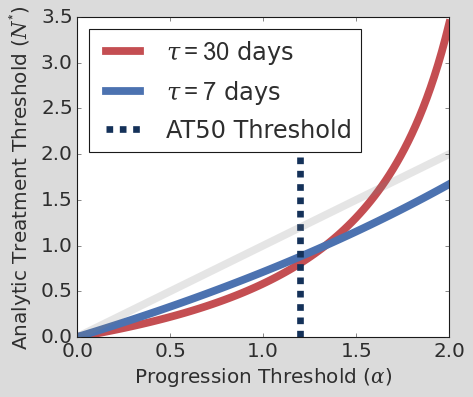

In [7]:
# Plot N* against alpha for different patient profiles or treatment times:

plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(6, 5))

progression_thresholds = np.linspace(0.01, 2, 100)
n0 = odeParamDic['n0']; rs = odeParamDic['rS']

n_stars_30 = [calc_critical_treatment_threshold(tau=28,**odeParamDic, prog=threshold) for threshold in progression_thresholds]
plt.plot(progression_thresholds, n_stars_30, linewidth = 7, label = r"$\tau = 30$ days", color='r'); 
n_stars_7 = [calc_critical_treatment_threshold(tau=7,**odeParamDic, prog=threshold) for threshold in progression_thresholds]
plt.plot(progression_thresholds, n_stars_7, linewidth = 7, label = r"$\tau = 7$ days", color='b'); 
ax.vlines(ymin=0, ymax=max(progression_thresholds), x=1.2,
          linestyles="--", linewidth=6, color=colors['AT'], label = 'AT50 Threshold')
plt.xlabel(r"Progression Threshold ($\alpha$)"); plt.ylabel(r"Analytic Treatment Threshold ($N^{*}$)"); plt.legend(loc=2);

plt.plot([0,max(progression_thresholds)], [0,max(progression_thresholds)], color='gray', alpha=0.2, linewidth=7);



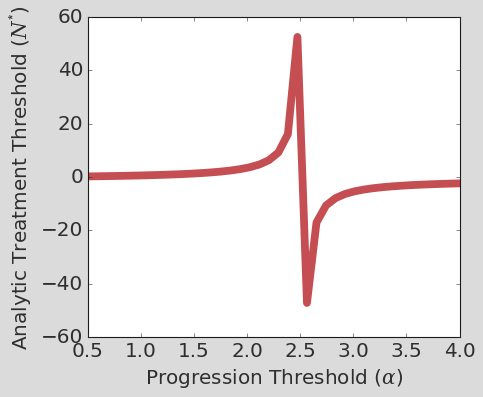

In [8]:
# We actually find a singularity when we consider a widered range of progression threshold

plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(6, 5))

progression_thresholds = np.linspace(0.5, 4, 40)

n_stars_30 = [calc_critical_treatment_threshold(tau=28,**odeParamDic, prog=threshold) for threshold in progression_thresholds]
plt.plot(progression_thresholds, n_stars_30, linewidth = 7, label = r"$\tau = 30$ days", color='r'); 

plt.xlabel(r"Progression Threshold ($\alpha$)"); plt.ylabel(r"Analytic Treatment Threshold ($N^{*}$)"); 



Revisiting the formula for the analytic threshold, we could have predicted this:

$$N^{*} = \frac{K(r_{S} - d_{S})}{\biggl(\frac{K(r_{S} - d_{S})}{\alpha N_{0}} - r_{S} \biggr)e^{(r_{S} - d_{S}) \tau} + r_{S}}$$

$N^{*}$ clearly diverges when the denominator is equal to zero, i.e.:

$$\biggl(r_{S} - \frac{K(r_{S} - d_{S})}{\alpha^{\dag} N_{0}} \biggr) e^{(r_{S} - d_{S}) \tau} = r_{S}$$

We may rearrange this condition to obtain this divergent threshold $\alpha^{\dag}$:

$$\alpha^{\dag} = \frac{K(r_{S} - d_{S})}{N_{0}r_{S}\bigl(1 - e^{-(r_{S} - d_{S}) \tau} \bigr)}$$

Computing this for this parameter set, it is approximately 2.5 (as observed graphically):

In [9]:
def calc_divergent_threshold(tau, S0, K, rS, dS, **kwargs):
    num = K*(rS - dS)
    den = S0 * rS * (1 - np.exp((dS - rS) * tau))
    return num / den

print(odeParamDic)
print(calc_divergent_threshold(tau=28,**odeParamDic))

{'n0': 0.75, 'rS': 0.027, 'rR': 0.027, 'dS': 0.0, 'dR': 0.0, 'dD': 1.5, 'K': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.74925, 'R0': 0.00075}
2.5160617434267554


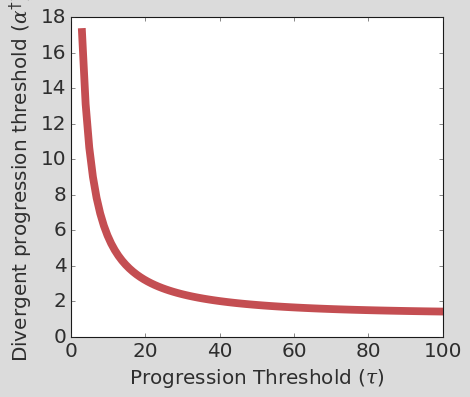

In [10]:
# How does this threshold vary with tau, the treatment interval? 

plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(6, 5))

treatment_intervals = np.linspace(3, 100, 100)
n_stars = [calc_divergent_threshold(tau=interval,**odeParamDic) for interval in treatment_intervals]
plt.plot(treatment_intervals, n_stars, linewidth = 7, color='r'); plt.ylim(bottom=0)

plt.xlabel(r"Progression Threshold ($\tau$)"); plt.ylabel(r"Divergent progression threshold ($\alpha^{\dag}$)"); 

* So this optimal treatment schedule doesn't break down as fast at more frequent treatment intervals.
* There is a minimal threshold that will always work (there will never be divergence), even at very long treatment intervals.

We may derive this minimal value of $\alpha^{\dag}$ by letting $\tau \to \infty$, to obtain:

$$\lim_{\tau \to \infty} \alpha^{\dag} = \frac{K(r_{S} - d_{S})}{N_{0}r_{S}}$$

This gives a clue as to the cause of this divergence. We have previously shown that the steady state of the system (under treatment) is given by:

$$ N(t) = \frac{K(r_{R} - d_{R})}{r_{R}} $$

Therefore when the progression threshold $\alpha^{\dag}N_{0}$ is greater than the steady state, we can never reach progression. Given our critical threshold is based on the highest treatment threshold that can never result in progression, this is longer well defined, and hence diverges.

In [11]:
def calc_steady_state(K, rS, dS, **kwargs):
    return (K * (rS - dS)) / rS

print(calc_steady_state(**odeParamDic))

1.0


## Benefitting from higher progression thresholds

To consider the benefit that patients might obtain from a higher progression threshold, we may compute $\frac{dN^{*}}{d\alpha}$:

$$\frac{d}{d\alpha}\Biggl(\frac{K(r_{S} - d_{S})}{\Bigl(\frac{K(r_{S} - d_{S})}{\alpha N} - r_{S}\Bigr) e^{(r_{S} - d_{S}) \tau} + r_S}\Biggr) = \frac{K^{2}\bigl(r_{S} - d_{S}\bigr)^{2} e^{(r_{S} - d_{S})\tau}}{N_{0} \alpha^{2} \biggl[e^{(r_{S} - d_{S})\tau} \Bigl(\frac{K(r_{S} - d_{S})}{N_{0}\alpha} - r_{S}\Bigr) + r_{S}\biggr]^{2}}$$

which we may rearrange this to the (moderately) more attractive form:

$$ \frac{dN^{*}}{d\alpha} = \frac{N_{0} e^{-(r_{S} - d_{S}) \tau}}{\biggl[1 + \frac{\alpha r_{S} N_{0}}{K (r_{S} - d_{S})} \Bigl(e^{-(r_{S} - d_{S}) \tau} - 1\Bigr)\biggr]^{2}}$$

In [12]:
def calc_threshold_derivative(tau, S0, K, rS, dS, prog, **kwargs):
    exp_term = np.exp((rS - dS) * tau)
    sub_brackets = ((K * (rS - dS)) / (prog * S0)) - rS
    brackets = (sub_brackets * exp_term) + rS
    return (K**2 * (rS - dS)**2 * exp_term) / (S0 * prog**2 * brackets**2)

In [13]:
def calc_threshold_derivative_alt(tau, S0, K, rS, dS, prog, **kwargs):
    exp_term = np.exp(-(rS - dS) * tau)
    pre_factor = (prog * rS * S0) / (K * (rS - dS))
    return (S0 * exp_term) / ( (1 + pre_factor * (exp_term - 1))**2)

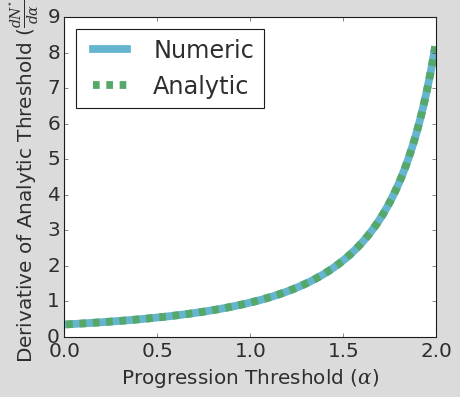

In [14]:
# Plot dN*/dalpha, comparing analytic and numeric methods:
fig, ax = plt.subplots(1,1,figsize=(6, 5))

progression_thresholds = np.linspace(0.01, 2, 100)
progression_step = progression_thresholds[1] - progression_thresholds[0]

n_star_series = [calc_critical_treatment_threshold(tau=28,**odeParamDic, prog=threshold) for threshold in progression_thresholds]
n_derivative_num = np.diff(n_star_series) / progression_step
progression_thresholds_shifted = progression_thresholds[:-1] + (progression_step / 2)

plt.plot(progression_thresholds_shifted, n_derivative_num, linewidth = 7, label = "Numeric", color='c'); 

n_derivative_ana = [calc_threshold_derivative(tau=28,**odeParamDic, prog=threshold) for threshold in progression_thresholds]
plt.plot(progression_thresholds, n_derivative_ana, linewidth = 7, linestyle = '--', label = "Analytic", color='g'); 

plt.xlabel(r"Progression Threshold ($\alpha$)"); plt.ylabel(r"Derivative of Analytic Threshold ($\frac{dN^{*}}{d\alpha}$)"); plt.legend(loc=2);

Can we them simulate these different progression thresholds, to determine how much the patient would actually benefit from the higher threshold (and whether the additional burden is worth it for them?)

In [15]:
# Set a progression limit of 2
# Then simulate identical patients at optimal thresholds for prog limit 1.2 and 2
# This is only for one patient, but worth determining how it changes for different patients (different K)


